## Debiasing Importance sampling

We consider a toy self-normalized importance sampling setup, and a technique to remove the bias from the standard importance sampling estimator.

In [1]:
# import package
using Random, Distributions, Plots, QuadGK, PrettyTables
# set seed
Random.seed!(123);

Define target and proposal:
* target is a mixture of Normals:
$0.2\text{Normal}(-1,1.2) +  0.5\text{Normal}(0, 1) + 0.3\text{Normal}(3, 2.5)$
* proposal is t-distribution with scale 2 and 3 degrees of freedom

The following plots the probability density functions of the <span style='color: orange'>target</span> and of the proposal.

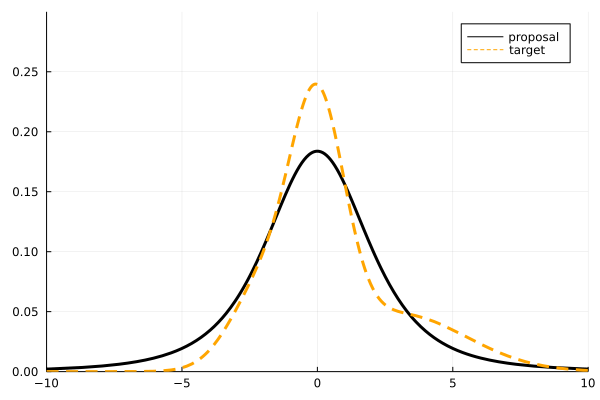

In [2]:
# define proposal
TDist2(μ, σ, ν) = μ + σ*TDist(ν)
proposal = TDist2(0, 2, 3)
# define target
target = MixtureModel(Normal[
   Normal(-2.0, 1.2),
   Normal(0.0, 1.0),
   Normal(3.0, 2.5)], [0.2, 0.5, 0.3])
# plot densities
xgrid = 0:0.1:16; yvalues = pdf.(proposal, xgrid);
q(x) = pdf.(proposal,x)
pi(x) = pdf.(target,x)
plot(xlims = (-10, 10), ylims = (0, .3))
plot!(q, seriescolor=:black, legend=true, linewidth=3, label = "proposal")
plot!(pi,seriescolor=:orange,linewidth=3,linestyle=:dash, label = "target")

### Ground truth

We consider the problem of computing the integral: $\int h(x) \pi(dx)$, with $h(x)= x^2 \cos(x)$.
We can do it by numerical integration, using adaptive Gauss-Kronrod quadrature. This gives us the ground truth for the following experiments.

In [3]:
h(x) = cos(x)*x^2
integrand(x) = h.(x)*pdf.(target, x)
integral = quadgk(integrand, -Inf, Inf, rtol=1e-5)
qoi = integral[1]
println("estimated integral of interest: ", round(qoi; digits = 4))
println("estimated upper bound on the error: ", round(integral[2]; digits = 8))

estimated integral of interest: -0.4053
estimated upper bound on the error: 2.79e-6


### Standard importance sampling

First, estimate the quantity of interest by importance sampling from the proposal distribution $q$.

In [4]:
# compute log-weight
function weight(x)
    logw = logpdf.(target, x) .- logpdf.(proposal, x)
    return logw
end
# normalize weights
function normweights(logw)
    maxlogw = maximum(logw)
    w = exp.(logw .- maxlogw)
    logavew = maxlogw + log(mean(w))
    nw = w / sum(w)
    return Dict("nw" => nw, "logavew" => logavew)
end
# importance sampling (self-normalized) with N draws
# returns x values, weights, and estimate of normalizing constant
function is(N)
    x = rand(proposal, N)
    logw = weight(x)
    processedw = normweights(logw)
    return Dict("x" => x, "nw" => processedw["nw"], "logavew" => processedw["logavew"])
end
# importance sampling estimation of \int h(x) \pi(dx)
N = 100000
is_result = is(N)
is_estimate = sum(h.(is_result["x"]) .* is_result["nw"])
is_var = sum(is_result["nw"].^2 .* (h.(is_result["x"]) .- is_estimate).^2)
is_low = is_estimate-1.96*sqrt(is_var)
is_high = is_estimate+1.96*sqrt(is_var)
println("IS estimate: ", round(is_estimate;digits=4), ", using ", N, " draws")
println("95% CLT-based confidence interval: [", round(is_low; digits=4),", ", round(is_high; digits=4), "]")
println("ground truth: ", round(qoi; digits = 4))

IS estimate: -0.3839, using 100000 draws
95% CLT-based confidence interval: [-0.4538, -0.3141]
ground truth: -0.4053


In [5]:
# Check coverage of 95% CLT-based confidence intervals
function confidence_contains_truth(N)
    is_result = is(N)
    is_estimate = sum(h.(is_result["x"]) .* is_result["nw"])
    is_var = sum(is_result["nw"].^2 .* (h.(is_result["x"]) .- is_estimate).^2)
    is_low = is_estimate-1.96*sqrt(is_var)
    is_high = is_estimate+1.96*sqrt(is_var)
    return (qoi > is_low) & (qoi < is_high)
end 
nrep = 5000
Nseq = [10, 100, 250, 500]
coverages = zeros(length(Nseq))
counter = 0
for N in Nseq
    counter += 1
    indicators = zeros(nrep)
    Threads.@threads for irep in 1:nrep
        indicators[irep] = confidence_contains_truth(N)
    end
    coverages[counter] = mean(indicators)
end
data = hcat(Int.(Nseq), coverages)
header = (["N", "coverage"], ["", string("(", nrep, " replications)")])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2)), compact_printing = true)

┌─────┬─────────────────────┐
│   N │            coverage │
│     │ (5000 replications) │
├─────┼─────────────────────┤
│  10 │                0.89 │
│ 100 │                0.89 │
│ 250 │                0.93 │
│ 500 │                0.94 │
└─────┴─────────────────────┘


Note: above it seems that we need quite a large value of $N$ in order to have
confidence intervals that have more or less the nominal coverage.

Below we check the bias of importance sampling when using a very small N, here $N=3$.
The following plots a histogram of IS estimates, with <span style='color: red'>the red full line indicating the mean
of the estimate</span>, and <span style='color: orange'>the orange dashed line indicating the ground truth</span>.

bias: -0.4836


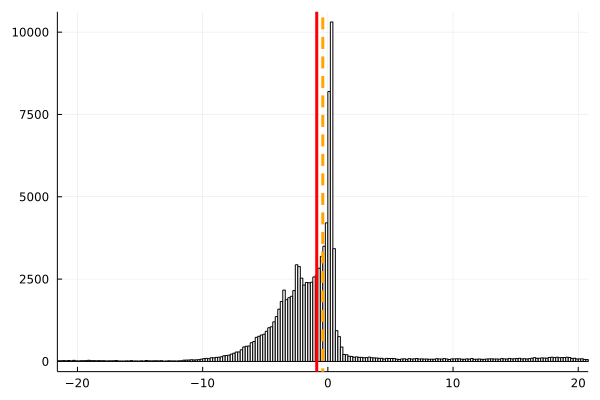

In [6]:
nrep = 100000
is_estimates = zeros(nrep)
Threads.@threads for irep in 1:nrep
    is_result = is(3)
    is_estimates[irep] = sum(h.(is_result["x"]) .* is_result["nw"])
end
p = histogram(is_estimates, legend = false, color = :white, xlims = [qoi-20, qoi+20])
vline!([qoi], color = :orange, linestyle=:dash, linewidth=3)
vline!([mean(is_estimates)], color = :red, linewidth=3)
println("bias: ", round(mean(is_estimates)-qoi; digits = 4))
display(p)

From the above plot, we see that the bias is visible when $N$ is very small.

Below we compute the bias and variance for various $N$, using many independent replications.

In [7]:
nrep = 100000
Nseq = [2, 4, 8, 16, 32, 64]
bias = zeros(length(Nseq))
variance = zeros(length(Nseq))
for iN in 1:length(Nseq)
    is_estimates = zeros(nrep)
    Threads.@threads for irep in 1:nrep
        is_result = is(Nseq[iN])
        is_estimates[irep] = sum(h.(is_result["x"]) .* is_result["nw"])
    end
    bias[iN] = mean(is_estimates .- qoi)
    variance[iN] = var(is_estimates)
end

data = hcat(Nseq, bias, bias.^2, variance)
header = (["N", "bias", "squared bias", "variance"])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2:4)), compact_printing = true)

┌────┬───────┬──────────────┬──────────┐
│  N │  bias │ squared bias │ variance │
├────┼───────┼──────────────┼──────────┤
│  2 │ -0.64 │         0.41 │    51.47 │
│  4 │ -0.37 │         0.14 │    25.27 │
│  8 │ -0.19 │         0.03 │    14.04 │
│ 16 │ -0.11 │         0.01 │     7.39 │
│ 32 │ -0.05 │         0.00 │     3.79 │
│ 64 │ -0.02 │         0.00 │     1.95 │
└────┴───────┴──────────────┴──────────┘


The cost of IS is measured as $N$. The squared bias is very small compared to the variance, but it is noticeable for very small $N$.

### Debiasing importance sampling

Now we look at removing the bias of self-normalized importance sampling completely.
The idea is to embed importance sampling in particle MCMC, see

* [ADH2010] Andrieu, Doucet & Holenstein, _[Particle Markov chain Monte Carlo methods](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2009.00736.x)_, 2010.

Then one can apply the debiasing technique pioneered in

* [GR2014] Glynn & Rhee, _[Exact estimation for Markov chain equilibrium expectations](https://www.cambridge.org/core/journals/journal-of-applied-probability/article/exact-estimation-for-markov-chain-equilibrium-expectations/844D4F8B0872C8516FE8B51B2BAA103B)_, 2014.

The technique implemented below is described in 

* [MDDJ2019] Middleton, Deligiannidis, Doucet & Jacob,
_[Unbiased Smoothing using Particle Independent Metropolis-Hastings](http://proceedings.mlr.press/v89/middleton19a.html)_, 2019.

We'll call that "method 1".

In [8]:
function debiasedis1(N)
    estimate = 0.
    state1 = is(N)
    estimate += sum(state1["nw"] .* h.(state1["x"]))
    state2 = is(N)
    tau = +Inf
    u = rand()
    if (log(u) < (state2["logavew"] - state1["logavew"]))
        tau = 1
    end
    time = 1
    while isinf(tau)
        estimate += sum(state1["nw"] .* h.(state1["x"])) - sum(state2["nw"] .* h.(state2["x"])) 
        time += 1
        stateproposal = is(N)
        u = rand()
        logacc1 = (stateproposal["logavew"] - state1["logavew"])
        logacc2 = (stateproposal["logavew"] - state2["logavew"])
        if (log(u) < logacc1)
            state1 = stateproposal
        end
        if (log(u) < logacc2)
            state2 = stateproposal
        end
        if (log(u) < logacc1) & (log(u) < logacc2)
            tau = time
        end
    end
    return Dict("estimate" => estimate, "tau" => tau)
end

debiasedis1 (generic function with 1 method)

The above algorithm is applicable in every case where importance sampling is applicable: it is a "meta-algorithm" that encapsulates importance sampling within a debiasing technique.

Below we see how it performs, for various choices of $N$.

In [9]:
# compute bias, variance, mean "meeting time", mean cost
bias_dis1 = zeros(length(Nseq))
variance_dis1 = zeros(length(Nseq))
meantau_dis1 = zeros(length(Nseq))
meancost_dis1 = zeros(length(Nseq))
estimates_dis1 = zeros(nrep)
taus_dis1 = zeros(nrep)
cost_dis1 = zeros(nrep)
# for each N
for iN in 1:length(Nseq)
    N = Nseq[iN]
    # for each repeat
    Threads.@threads for irep in 1:nrep
        # run algorithm
        dis_result = debiasedis1(N)
        estimates_dis1[irep] = dis_result["estimate"]
        taus_dis1[irep] = dis_result["tau"]
        cost_dis1[irep] = 2*N + (taus_dis1[irep]-1)*N
    end
    # compute bias, variance, mean "meeting time", mean cost
    bias_dis1[iN] = mean(estimates_dis1 .- qoi)
    variance_dis1[iN] = var(estimates_dis1)
    meantau_dis1[iN] = mean(taus_dis1)
    meancost_dis1[iN] = mean(cost_dis1)
end
# print results
data = hcat(Nseq, bias_dis1, bias_dis1.^2, variance_dis1, meantau_dis1, meancost_dis1)
header = (["N", "bias", "squared bias", "variance", "mean tau", "mean cost"])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2:6)), compact_printing = true)

┌────┬───────┬──────────────┬──────────┬──────────┬───────────┐
│  N │  bias │ squared bias │ variance │ mean tau │ mean cost │
├────┼───────┼──────────────┼──────────┼──────────┼───────────┤
│  2 │  0.06 │         0.00 │   117.68 │     1.15 │      4.30 │
│  4 │ -0.04 │         0.00 │    44.47 │     1.10 │      8.42 │
│  8 │ -0.01 │         0.00 │    20.67 │     1.07 │     16.58 │
│ 16 │ -0.00 │         0.00 │     9.52 │     1.05 │     32.81 │
│ 32 │ -0.01 │         0.00 │     4.55 │     1.04 │     65.15 │
│ 64 │  0.01 │         0.00 │     2.20 │     1.03 │    129.62 │
└────┴───────┴──────────────┴──────────┴──────────┴───────────┘


### More efficient version

Below is a slight variation of method 1 where we "Rao-Blackwellize" the order of the two initial states of the chains. That is, we propose the second chain to the first, and we propose the first chain to the second; at least one proposal will get accepted at time 1.

The modification yields a twofold improvement in efficiency as $N\to \infty$.

We'll call that "method 2".

In [10]:
function debiasedis2(N)
    estimate = 0.
    state1 = is(N)
    state2 = is(N)
    if (state1["logavew"] < state2["logavew"])
        swap = state2
        state2 = state1
        state1 = swap
    end
    estimate1 = sum(state1["nw"] .* h.(state1["x"]))
    estimate2 = sum(state2["nw"] .* h.(state2["x"]))
    tau = +Inf
    u = rand()
    if (log(u) < (state2["logavew"] - state1["logavew"]))
        tau = 1
    end
    time = 1
    while isinf(tau)
        estimate1 += sum(state1["nw"] .* h.(state1["x"])) - sum(state2["nw"] .* h.(state2["x"]))
        time += 1
        stateproposal = is(N)
        u = rand()
        logacc1 = (stateproposal["logavew"] - state1["logavew"])
        logacc2 = (stateproposal["logavew"] - state2["logavew"])
        if (log(u) < logacc1)
            state1 = stateproposal
        end
        if (log(u) < logacc2)
            state2 = stateproposal
        end
        if (log(u) < logacc1) & (log(u) < logacc2)
            tau = time
        end
    end
    return Dict("estimate" => 0.5*estimate1+0.5*estimate2, "tau" => tau)
end

debiasedis2 (generic function with 1 method)

In [11]:
# compute bias, variance, mean "meeting time", mean cost
bias_dis2 = zeros(length(Nseq))
variance_dis2 = zeros(length(Nseq))
meantau_dis2 = zeros(length(Nseq))
meancost_dis2 = zeros(length(Nseq))
estimates_dis2 = zeros(nrep)
taus_dis2 = zeros(nrep)
cost_dis2 = zeros(nrep)
# for each N
for iN in 1:length(Nseq)
    N = Nseq[iN]
    # for each repeat
    Threads.@threads for irep in 1:nrep
        # run algorithm
        dis_result = debiasedis2(N)
        estimates_dis2[irep] = dis_result["estimate"]
        taus_dis2[irep] = dis_result["tau"]
        cost_dis2[irep] = 2*N + (taus_dis2[irep]-1)*N
    end
    # compute bias, variance, mean "meeting time", mean cost
    bias_dis2[iN] = mean(estimates_dis2 .- qoi)
    variance_dis2[iN] = var(estimates_dis2)
    meantau_dis2[iN] = mean(taus_dis2)
    meancost_dis2[iN] = mean(cost_dis2)
end
# print results
data = hcat(Nseq, bias_dis2, bias_dis2.^2, variance_dis2, meantau_dis2, meancost_dis2)
header = (["N", "bias", "squared bias", "variance", "mean tau", "mean cost"])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2:6)), compact_printing = true)

┌────┬───────┬──────────────┬──────────┬──────────┬───────────┐
│  N │  bias │ squared bias │ variance │ mean tau │ mean cost │
├────┼───────┼──────────────┼──────────┼──────────┼───────────┤
│  2 │  0.00 │         0.00 │    45.24 │     1.30 │      4.60 │
│  4 │  0.01 │         0.00 │    20.35 │     1.21 │      8.83 │
│  8 │  0.00 │         0.00 │     9.52 │     1.15 │     17.18 │
│ 16 │ -0.00 │         0.00 │     4.48 │     1.10 │     33.66 │
│ 32 │ -0.00 │         0.00 │     2.15 │     1.07 │     66.34 │
│ 64 │  0.00 │         0.00 │     1.06 │     1.05 │    131.25 │
└────┴───────┴──────────────┴──────────┴──────────┴───────────┘


As can be seen from the above tables:

* the bias of self-normalized importance sampling can be removed completely for a moderate cost

* "method 1" above provides unbiased estimators, that are visibly less efficient than self-normalized importance sampling, but asymptotically $N\to \infty$ the efficiency ratio should converge to 2,

* "method 2" above achieves, as $N\to \infty$ the same efficiency as self-normalized importance sampling. 

The table below compares these products, called "inefficiencies" (lower is better!), see

* [GW1992] Glynn & Whitt, _[The asymptotic efficiency of simulation estimators](https://pubsonline.informs.org/doi/abs/10.1287/opre.40.3.505)_, 1992,

for method 1, method 2 and standard importance sampling.

In [12]:
data = hcat(Nseq, variance_dis1 .* meancost_dis1, variance_dis2 .* meancost_dis2, (bias.^2 .+ variance) .* Nseq)
header = (["N", "inefficiencies", "", ""], ["", "method 1", "method 2", "importance sampling"])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2:4)), compact_printing = true)

┌────┬────────────────┬──────────┬─────────────────────┐
│  N │ inefficiencies │          │                     │
│    │       method 1 │ method 2 │ importance sampling │
├────┼────────────────┼──────────┼─────────────────────┤
│  2 │         506.34 │   208.13 │              103.76 │
│  4 │         374.30 │   179.70 │              101.62 │
│  8 │         342.72 │   163.60 │              112.59 │
│ 16 │         312.52 │   150.90 │              118.46 │
│ 32 │         296.16 │   142.60 │              121.46 │
│ 64 │         285.40 │   139.13 │              124.59 │
└────┴────────────────┴──────────┴─────────────────────┘


It is funny that the inefficiencies of importance sampling increase with $N\to\infty$. This seems to indicate that the IS estimator is not yet in its asymptotic regime in $N$ (see also the experiments on coverage above, which also support the hypothesis that a large $N$ is required for standard IS to be in its asymptotic regime).

*The main message is that importance sampling can be debiased, generically, at an added cost that becomes negligible as $N\to\infty$.*

#### Alternative debiasing schemes and variance reduction

1. The above estimators are based on the "particle independent Metropolis-Hastings" algorithm, but we can also debias "particle Gibbs" sampler, as was done in 

* JLS2019] Jacob, Lindsten & Schön, _[Smoothing With Couplings of Conditional Particle Filters](https://www.tandfonline.com/doi/abs/10.1080/01621459.2018.1548856?journalCode=uasa20)_, 2019.

* [LSV2020] Lee, Singh & Vihola, _[Coupled conditional backward sampling particle filter](https://projecteuclid.org/journals/annals-of-statistics/volume-48/issue-5/Coupled-conditional-backward-sampling-particle-filter/10.1214/19-AOS1922.short)_, 2020.

Again, self-normalized importance sampling is retrieved as a particular case when the "time horizon" is equal to one, so these works provide de-biased importance sampling estimators, even though the focus in these articles is on more general particle filters.


2. The above experiments correspond to the $H_{0}$ estimator in 

* [JOA2020] Jacob, O'Leary, Atchadé, _[Unbiased Markov chain Monte Carlo methods with couplings](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssb.12336)_, 2020.

That article, and also JLS2019 mentioned above and follow-ups since then, introduce variance reduction techniques that could be applied here, particularly for small $N$.